In [1]:
# !pip install tensorflow-gpu matplotlib tqdm numpy seaborn

In [2]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import seaborn as sns
import re
import ast
import os


sns.set()
plt.rc('font', family = 'serif')
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20 

In [3]:
class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

IMGWIDTH = 256

In [4]:
class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)

In [5]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [6]:
class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


In [7]:
def get_meso_model(model_name):
    if model_name == "Meso4_DF":
        model = Meso4()
        model.load("../_WEIGHTS/og_mesonet_weights/Meso4_DF.h5")
    elif model_name == "Meso4_F2F":
        model = Meso4()
        model.load("../_WEIGHTS/og_mesonet_weights/Meso4_F2F.h5")
    elif model_name == "MesoInception_DF":
        model = MesoInception4()
        model.load("../_WEIGHTS/og_mesonet_weights/MesoInception_DF.h5")
    elif model_name == "MesoInception_F2F":
        model = MesoInception4()
        model.load("../_WEIGHTS/og_mesonet_weights/MesoInception_F2F.h5")
    return model


In [8]:
def get_binary_testset(dataset_name):
    """
    dataset_name -> trainset, valset, testset
    """
    trainset, valset, testset = None, None, None
    dataset_name = dataset_name.lower()
    path_2_root = ".."

    if not "oc" in dataset_name:
        if "dar" in dataset_name and "oc" not in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/validation"

        if "avg" in dataset_name: # Celeb-avg-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_avg"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_avg"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_avg"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_avg"

        elif "rnd" in dataset_name: # Celeb-rnd-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_rnd"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_rnd"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_rnd"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_rnd"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_rnd"

        elif "diff" in dataset_name: # Celeb-diff-30
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

    else: # oc
        if "dar" in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/" # unary
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/" # binary

        elif "avg" in dataset_name:
            pass

        elif "rnd" in dataset_name: # Celeb-rnd-30-OC
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/" # unary
            valset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"  # unary
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/" # binary

    testset = trainset if testset==None else testset
    valset = trainset if valset==None else valset
    return trainset, valset, testset

In [9]:
SEED = 1337
# CLASSIFIER = get_meso_model("Meso4_DF")
# DATASET = get_binary_testset("DariusAf_Deepfake_Database")

In [10]:
# IMG_DATAGEN = ImageDataGenerator(rescale=1./255)
# GEN = IMG_DATAGEN.flow_from_directory(DATASET,
#                                       target_size=(IMGWIDTH, IMGWIDTH),
#                                       batch_size=128,
#                                       seed=SEED,
#                                       class_mode="binary") 
# possible_batch_sizes = [b for b in range(1, GEN.samples) if not GEN.samples % b]
# possible_batch_sizes = [b for b in possible_batch_sizes if b<4096][::-1]
# GEN.batch_size = possible_batch_sizes[0]

# print(f"Possible batch sizes: {possible_batch_sizes}")
# print(f"Chosen batch size: {GEN.batch_size}")

In [11]:
              # experiment_name,                                       model_name,          testset_name,                 fname
EXPERIMENTS = [ # ROUND 1, Default MesoNets w/ dataset provided by paper author
            #    ("Meso4 w/ DF Weights \nTested on DFDB Dataset",          "Meso4_DF",           "DariusAf_Deepfake_Database", "Meso4_DF_DFDB"),
            #    ("Meso4 w/ F2F Weights \nTested on DFDB Dataset",         "Meso4_F2F",          "DariusAf_Deepfake_Database", "Meso4_F2F_DFDB"),
            #    ("MesoInception4 w/ DF Weights \nTested on DFDB Dataset", "MesoInception_DF",   "DariusAf_Deepfake_Database", "MesoInception_DF_DFDB"),
            #    ("MesoInception4 w/ F2F Weights \nTested on DFDB Dataset", "MesoInception_F2F", "DariusAf_Deepfake_Database", "MesoInception_F2F_DFDB"),

            #     # ROUND 2, MesoInception_DF_DFDB and Meso4_DF_DFDB heightest AUC at 0.990 and 0.984, respectively
            #    ("MesoInception4 w/ DF Weights\
            #    \nTested on AVG CDFv2 Dataset",         "MesoInception_DF",  "Celeb-avg-30-test", "MesoInception_DF_CDFv2avg"),

            #    ("MesoInception4 w/ DF Weights\
            #    \nTested on RND CDFv2 Dataset",   "MesoInception_DF",  "Celeb-rnd-30-test", "MesoInception_DF_CDFv2rnd"),

            #    ("Meso4 w/ DF Weights\
            #    \nTested on AVG CDFv2 Dataset",         "Meso4_DF",          "Celeb-avg-30-test", "Meso4_DF_CDFv2avg"),

            #    ("Meso4 w/ DF Weights\
            #    \nTested on RND CDFv2 Dataset",   "Meso4_DF",          "Celeb-rnd-30-test", "Meso4_DF_CDFv2rnd"),

            #    # ROUND 2.1, Just to check... performance of F2F equivielents (allows us to rule out avg datasets)
            #    ("MesoInception4 w/ F2F Weights\
            #    \nTested on AVG CDFv2 Dataset",         "MesoInception_F2F", "Celeb-avg-30-test", "MesoInception_F2F_CDFv2avg"),

            #    ("MesoInception4 w/ F2F Weights\
            #    \nTested on RND CDFv2 Dataset",   "MesoInception_F2F", "Celeb-rnd-30-test", "MesoInception_F2F_CDFv2rnd"),

            #    ("Meso4 w/ F2F Weights\
            #    \nTested on AVG CDFv2 Dataset",         "Meso4_F2F",         "Celeb-avg-30-test", "Meso4_F2F_CDFv2avg"),

            #    ("Meso4 w/ F2F Weights\
            #    \nTested on RND CDFv2 Dataset",   "Meso4_F2F",         "Celeb-rnd-30-test", "Meso4_F2F_CDFv2rnd"),

            #    # ROUND 2.2, Running AVG, set of images from each video is single data point
            #    ("MesoInception4 w/ DF Weights\
            #    \nTested on AVG CDFv2 Dataset\
            #    \nRunning Average Evaluation", "MesoInception_DF", "Celeb-avg-30-test", "MesoInception_DF_CDFv2runningavg"),

            #    ("MesoInception4 w/ DF Weights\
            #    \nTested on RND CDFv2 Dataset\
            #    \n(Single Random Face Frames Every 0.5s Interval)\
            #    \nRunning Average Evaluation",  "MesoInception_DF", "Celeb-rnd-30-test", "MesoInception_DF_CDFv2runningrnd"),

            #    ("Meso4 w/ DF Weights\
            #    \nTested on AVG CDFv2 Dataset\
            #    \nRunning Average Evaluation",  "Meso4_DF", "Celeb-avg-30-test", "Meso4_DF_CDFv2runningavg"),

            #    ("Meso4 w/ DF Weights\
            #    \nTested on RND CDFv2 Dataset\
            #    \nRunning Average Evaluation",  "Meso4_DF", "Celeb-rnd-30-test", "Meso4_DF_CDFv2runningrnd"),

            #    ("MesoInception4 w/ F2F Weights\
            #    \nTested on AVG CDFv2 Dataset\
            #    \nRunning Average Evaluation",   "MesoInception_F2F", "Celeb-avg-30-test", "MesoInception_F2F_CDFv2runningavg"),

            #    ("MesoInception4 w/ F2F Weights\
            #    \nTested on RND CDFv2 Dataset\
            #    \nRunning Average Evaluation",  "MesoInception_F2F", "Celeb-rnd-30-test", "MesoInception_F2F_CDFv2runningrnd"),

            #    ("Meso4 w/ F2F Weights\
            #    \nTested on AVG CDFv2 Dataset\
            #    \nRunning Average Evaluation",  "Meso4_F2F", "Celeb-avg-30-test", "Meso4_F2F_CDFv2runningavg"),

            #    ("Meso4 w/ F2F Weights\
            #    \nTested on RND CDFv2 Dataset\
            #    \nRunning Average Evaluation",  "Meso4_F2F", "Celeb-rnd-30-test", "Meso4_F2F_CDFv2runningrnd"),

            #     # DF
            #     (f"Meso4 w/ F2F Weights\
            #    \nTested on AVG Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"Meso4_F2F", "Deepfakes_avg", f"Meso4_F2F_raeonDFavg"),
             
            #     (f"Meso4 w/ F2F Weights\
            #    \nTested on AVG Deepfakes Dataset",  f"Meso4_F2F", "Deepfakes_avg", f"Meso4_F2F_DFavg"),
             
            #     (f"Meso4 w/ F2F Weights\
            #    \nTested on RND Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"Meso4_F2F", "Deepfakes_rnd", f"Meso4_F2F_raeonDFrnd"),
             
            #     (f"Meso4 w/ F2F Weights\
            #    \nTested on RND Deepfakes Dataset",  f"Meso4_F2F", "Deepfakes_rnd", f"Meso4_F2F_DFrnd"),

            #     # F2F
                (f"Meso4 w/ F2F Weights\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"Meso4_F2F", "Face2Face_avg", f"Meso4_F2F_raeonF2Favg"),
             
                (f"Meso4 w/ F2F Weights\
                \nTested on AVG Face2Face Dataset",  f"Meso4_F2F", "Face2Face_avg", f"Meso4_F2F_F2Favg"),
              
                (f"Meso4 w/ F2F Weights\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"Meso4_F2F", "Face2Face_rnd", f"Meso4_F2F_raeonF2Frnd"),
               
                (f"Meso4 w/ F2F Weights\
                \nTested on RND Face2Face Dataset",  f"Meso4_F2F", "Face2Face_rnd", f"Meso4_F2F_F2Frnd"),

            # #     # FaceShifter
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG FaceShifter Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "FaceShifter_avg", f"Meso4_F2F_raeonFSHFTavg"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG FaceShifter Dataset",  f"Meso4_F2F", "FaceShifter_avg", f"Meso4_F2F_FSHFTavg"),
               
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND FaceShifter Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "FaceShifter_rnd", f"Meso4_F2F_raeonFSHFTrnd"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND FaceShifter Dataset",  f"Meso4_F2F", "FaceShifter_rnd", f"Meso4_F2F_FSHFTrnd"),

            #     # FaceSwap
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG FaceSwap Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "FaceSwap_avg", f"Meso4_F2F_raeonFSavg"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG FaceSwap Dataset",  f"Meso4_F2F", "FaceSwap_avg", f"Meso4_F2F_FSavg"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND FaceSwap Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "FaceSwap_rnd", f"Meso4_F2F_raeonFSrnd"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND FaceSwap Dataset",  f"Meso4_F2F", "FaceSwap_rnd", f"Meso4_F2F_FSrnd"),

            #     # NeuralTextures
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG NeuralTextures Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "NeuralTextures_avg", f"Meso4_F2F_raeonNTavg"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on AVG NeuralTextures Dataset",  f"Meso4_F2F", "NeuralTextures_avg", f"Meso4_F2F_NTavg"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND NeuralTextures Dataset\
            #     \nRunning Average Evaluation",  f"Meso4_F2F", "NeuralTextures_rnd", f"Meso4_F2F_raeonNTrnd"),
                
            #     (f"Meso4 w/ F2F Weights\
            #     \nTested on RND NeuralTextures Dataset",  f"Meso4_F2F", "NeuralTextures_rnd", f"Meso4_F2F_NTrnd"),


            #                     # DF
            #     (f"Meso4 w/ DF Weights\
            #    \nTested on AVG Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"Meso4_DF", "Deepfakes_avg", f"Meso4_DF_raeonDFavg"),
             
            #     (f"Meso4 w/ DF Weights\
            #    \nTested on AVG Deepfakes Dataset",  f"Meso4_DF", "Deepfakes_avg", f"Meso4_DF_DFavg"),
             
            #     (f"Meso4 w/ DF Weights\
            #    \nTested on RND Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"Meso4_DF", "Deepfakes_rnd", f"Meso4_DF_raeonDFrnd"),
             
            #     (f"Meso4 w/ DF Weights\
            #    \nTested on RND Deepfakes Dataset",  f"Meso4_DF", "Deepfakes_rnd", f"Meso4_DF_DFrnd"),

                # DF
                (f"Meso4 w/ DF Weights\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"Meso4_DF", "Face2Face_avg", f"Meso4_DF_raeonF2Favg"),
             
                (f"Meso4 w/ DF Weights\
                \nTested on AVG Face2Face Dataset",  f"Meso4_DF", "Face2Face_avg", f"Meso4_DF_F2Favg"),
              
                (f"Meso4 w/ DF Weights\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"Meso4_DF", "Face2Face_rnd", f"Meso4_DF_raeonF2Frnd"),
               
                (f"Meso4 w/ DF Weights\
                \nTested on RND Face2Face Dataset",  f"Meso4_DF", "Face2Face_rnd", f"Meso4_DF_F2Frnd"),

                # # FaceShifter
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG FaceShifter Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "FaceShifter_avg", f"Meso4_DF_raeonFSHFTavg"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG FaceShifter Dataset",  f"Meso4_DF", "FaceShifter_avg", f"Meso4_DF_FSHFTavg"),
               
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND FaceShifter Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "FaceShifter_rnd", f"Meso4_DF_raeonFSHFTrnd"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND FaceShifter Dataset",  f"Meso4_DF", "FaceShifter_rnd", f"Meso4_DF_FSHFTrnd"),

                # # FaceSwap
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG FaceSwap Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "FaceSwap_avg", f"Meso4_DF_raeonFSavg"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG FaceSwap Dataset",  f"Meso4_DF", "FaceSwap_avg", f"Meso4_DF_FSavg"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND FaceSwap Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "FaceSwap_rnd", f"Meso4_DF_raeonFSrnd"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND FaceSwap Dataset",  f"Meso4_DF", "FaceSwap_rnd", f"Meso4_DF_FSrnd"),

                # # NeuralTextures
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG NeuralTextures Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "NeuralTextures_avg", f"Meso4_DF_raeonNTavg"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on AVG NeuralTextures Dataset",  f"Meso4_DF", "NeuralTextures_avg", f"Meso4_DF_NTavg"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND NeuralTextures Dataset\
                # \nRunning Average Evaluation",  f"Meso4_DF", "NeuralTextures_rnd", f"Meso4_DF_raeonNTrnd"),
                
                # (f"Meso4 w/ DF Weights\
                # \nTested on RND NeuralTextures Dataset",  f"Meso4_DF", "NeuralTextures_rnd", f"Meso4_DF_NTrnd"),


                # DF
                (f"MesoInception4 w/ F2F Weights\
               \nTested on AVG Deepfakes Dataset\
               \nRunning Average Evaluation",  f"MesoInception_F2F", "Deepfakes_avg", f"MesoInception_F2F_raeonDFavg"),
             
                (f"MesoInception4 w/ F2F Weights\
               \nTested on AVG Deepfakes Dataset",  f"MesoInception_F2F", "Deepfakes_avg", f"MesoInception_F2F_DFavg"),
             
                (f"MesoInception4 w/ F2F Weights\
               \nTested on RND Deepfakes Dataset\
               \nRunning Average Evaluation",  f"MesoInception_F2F", "Deepfakes_rnd", f"MesoInception_F2F_raeonDFrnd"),
             
                (f"MesoInception4 w/ F2F Weights\
               \nTested on RND Deepfakes Dataset",  f"MesoInception_F2F", "Deepfakes_rnd", f"MesoInception_F2F_DFrnd"),

            #     # F2F
                (f"MesoInception4 w/ F2F Weights\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"MesoInception_F2F", "Face2Face_avg", f"MesoInception_F2F_raeonF2Favg"),
             
                (f"MesoInception4 w/ F2F Weights\
                \nTested on AVG Face2Face Dataset",  f"MesoInception_F2F", "Face2Face_avg", f"MesoInception_F2F_F2Favg"),
              
                (f"MesoInception4 w/ F2F Weights\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"MesoInception_F2F", "Face2Face_rnd", f"MesoInception_F2F_raeonF2Frnd"),
               
                (f"MesoInception4 w/ F2F Weights\
                \nTested on RND Face2Face Dataset",  f"MesoInception_F2F", "Face2Face_rnd", f"MesoInception_F2F_F2Frnd"),

            #     # FaceShifter
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG FaceShifter Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "FaceShifter_avg", f"MesoInception_F2F_raeonFSHFTavg"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG FaceShifter Dataset",  f"MesoInception_F2F", "FaceShifter_avg", f"MesoInception_F2F_FSHFTavg"),
               
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND FaceShifter Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "FaceShifter_rnd", f"MesoInception_F2F_raeonFSHFTrnd"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND FaceShifter Dataset",  f"MesoInception_F2F", "FaceShifter_rnd", f"MesoInception_F2F_FSHFTrnd"),

            #     # FaceSwap
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG FaceSwap Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "FaceSwap_avg", f"MesoInception_F2F_raeonFSavg"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG FaceSwap Dataset",  f"MesoInception_F2F", "FaceSwap_avg", f"MesoInception_F2F_FSavg"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND FaceSwap Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "FaceSwap_rnd", f"MesoInception_F2F_raeonFSrnd"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND FaceSwap Dataset",  f"MesoInception_F2F", "FaceSwap_rnd", f"MesoInception_F2F_FSrnd"),

            #     # NeuralTextures
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG NeuralTextures Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "NeuralTextures_avg", f"MesoInception_F2F_raeonNTavg"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on AVG NeuralTextures Dataset",  f"MesoInception_F2F", "NeuralTextures_avg", f"MesoInception_F2F_NTavg"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND NeuralTextures Dataset\
            #     \nRunning Average Evaluation",  f"MesoInception_F2F", "NeuralTextures_rnd", f"MesoInception_F2F_raeonNTrnd"),
                
            #     (f"MesoInception4 w/ F2F Weights\
            #     \nTested on RND NeuralTextures Dataset",  f"MesoInception_F2F", "NeuralTextures_rnd", f"MesoInception_F2F_NTrnd"),


            #     # DF
            #     (f"MesoInception4 w/ DF Weights\
            #    \nTested on AVG Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"MesoInception_DF", "Deepfakes_avg", f"MesoInception_DF_raeonDFavg"),
             
            #     (f"MesoInception4 w/ DF Weights\
            #    \nTested on AVG Deepfakes Dataset",  f"MesoInception_DF", "Deepfakes_avg", f"MesoInception_DF_DFavg"),
             
            #     (f"MesoInception4 w/ DF Weights\
            #    \nTested on RND Deepfakes Dataset\
            #    \nRunning Average Evaluation",  f"MesoInception_DF", "Deepfakes_rnd", f"MesoInception_DF_raeonDFrnd"),
             
            #     (f"MesoInception4 w/ DF Weights\
            #    \nTested on RND Deepfakes Dataset",  f"MesoInception_DF", "Deepfakes_rnd", f"MesoInception_DF_DFrnd"),

                # F2F
                (f"MesoInception4 w/ DF Weights\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"MesoInception_DF", "Face2Face_avg", f"MesoInception_DF_raeonF2Favg"),
             
                (f"MesoInception4 w/ DF Weights\
                \nTested on AVG Face2Face Dataset",  f"MesoInception_DF", "Face2Face_avg", f"MesoInception_DF_F2Favg"),
              
                (f"MesoInception4 w/ DF Weights\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"MesoInception_DF", "Face2Face_rnd", f"MesoInception_DF_raeonF2Frnd"),
               
                (f"MesoInception4 w/ DF Weights\
                \nTested on RND Face2Face Dataset",  f"MesoInception_DF", "Face2Face_rnd", f"MesoInception_DF_F2Frnd"),

                # # FaceShifter
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG FaceShifter Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "FaceShifter_avg", f"MesoInception_DF_raeonFSHFTavg"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG FaceShifter Dataset",  f"MesoInception_DF", "FaceShifter_avg", f"MesoInception_DF_FSHFTavg"),
               
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND FaceShifter Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "FaceShifter_rnd", f"MesoInception_DF_raeonFSHFTrnd"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND FaceShifter Dataset",  f"MesoInception_DF", "FaceShifter_rnd", f"MesoInception_DF_FSHFTrnd"),

                # # FaceSwap
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG FaceSwap Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "FaceSwap_avg", f"MesoInception_DF_raeonFSavg"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG FaceSwap Dataset",  f"MesoInception_DF", "FaceSwap_avg", f"MesoInception_DF_FSavg"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND FaceSwap Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "FaceSwap_rnd", f"MesoInception_DF_raeonFSrnd"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND FaceSwap Dataset",  f"MesoInception_DF", "FaceSwap_rnd", f"MesoInception_DF_FSrnd"),

                # # NeuralTextures
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG NeuralTextures Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "NeuralTextures_avg", f"MesoInception_DF_raeonNTavg"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on AVG NeuralTextures Dataset",  f"MesoInception_DF", "NeuralTextures_avg", f"MesoInception_DF_NTavg"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND NeuralTextures Dataset\
                # \nRunning Average Evaluation",  f"MesoInception_DF", "NeuralTextures_rnd", f"MesoInception_DF_raeonNTrnd"),
                
                # (f"MesoInception4 w/ DF Weights\
                # \nTested on RND NeuralTextures Dataset",  f"MesoInception_DF", "NeuralTextures_rnd", f"MesoInception_DF_NTrnd"),

               ]

In [12]:
# len(EXPERIMENTS)

Meso4 w/ F2F Weights  
Tested on AVG Face2Face Dataset  
Running Average Evaluation Meso4_F2F Face2Face_avg Meso4_F2F_raeonF2Favg
Found 42587 images belonging to 2 classes.


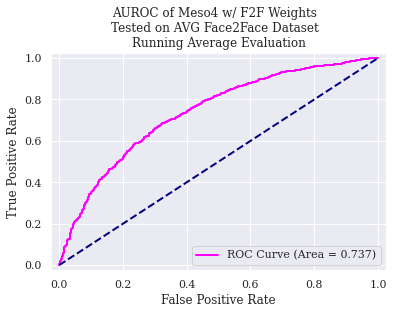

Meso4 w/ F2F Weights  
Tested on AVG Face2Face Dataset Meso4_F2F Face2Face_avg Meso4_F2F_F2Favg
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [01:59<00:00, 11.17it/s]


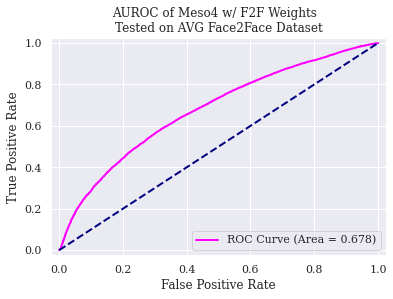

Meso4 w/ F2F Weights  
Tested on RND Face2Face Dataset  
Running Average Evaluation Meso4_F2F Face2Face_rnd Meso4_F2F_raeonF2Frnd
Found 42587 images belonging to 2 classes.


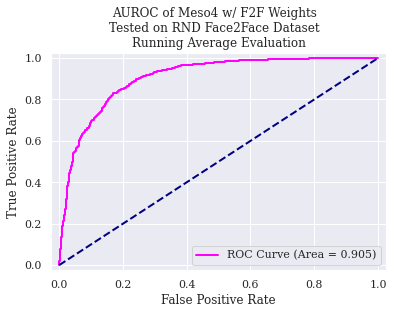

Meso4 w/ F2F Weights  
Tested on RND Face2Face Dataset Meso4_F2F Face2Face_rnd Meso4_F2F_F2Frnd
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:21<00:00,  9.42it/s]


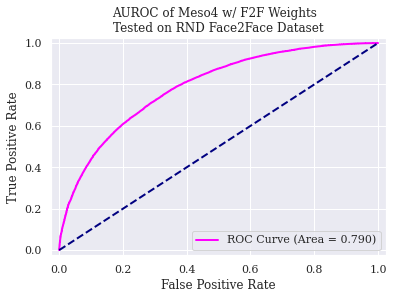

Meso4 w/ DF Weights  
Tested on AVG Face2Face Dataset  
Running Average Evaluation Meso4_DF Face2Face_avg Meso4_DF_raeonF2Favg
Found 42587 images belonging to 2 classes.


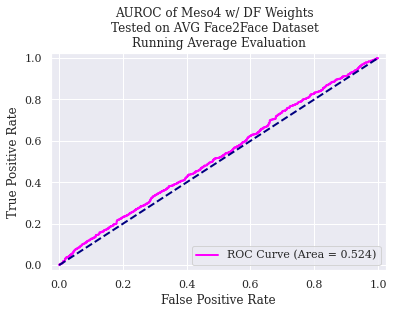

Meso4 w/ DF Weights  
Tested on AVG Face2Face Dataset Meso4_DF Face2Face_avg Meso4_DF_F2Favg
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:02<00:00, 10.84it/s]


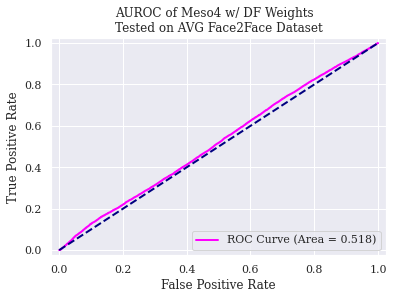

Meso4 w/ DF Weights  
Tested on RND Face2Face Dataset  
Running Average Evaluation Meso4_DF Face2Face_rnd Meso4_DF_raeonF2Frnd
Found 42587 images belonging to 2 classes.


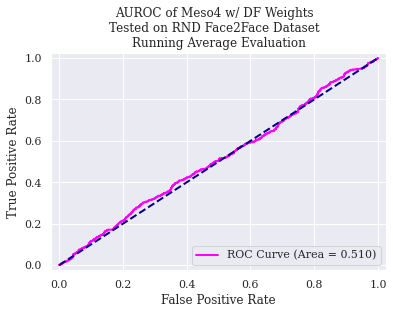

Meso4 w/ DF Weights  
Tested on RND Face2Face Dataset Meso4_DF Face2Face_rnd Meso4_DF_F2Frnd
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:02<00:00, 10.87it/s]


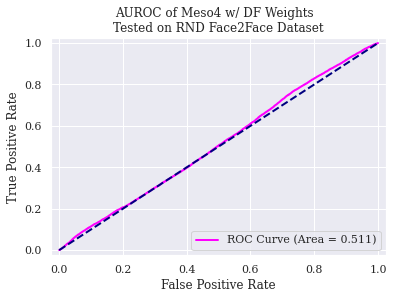

MesoInception4 w/ F2F Weights 
Tested on AVG Deepfakes Dataset 
Running Average Evaluation MesoInception_F2F Deepfakes_avg MesoInception_F2F_raeonDFavg
Found 42582 images belonging to 2 classes.


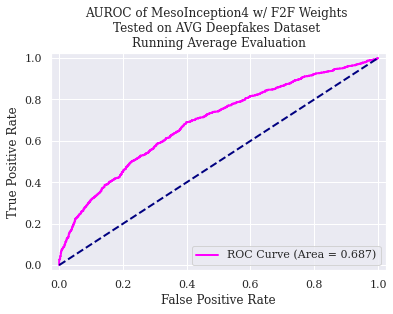

MesoInception4 w/ F2F Weights 
Tested on AVG Deepfakes Dataset MesoInception_F2F Deepfakes_avg MesoInception_F2F_DFavg
Found 42582 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:11<00:00, 10.14it/s]


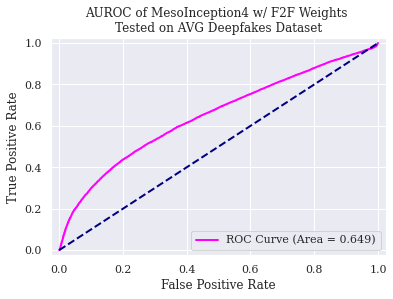

MesoInception4 w/ F2F Weights 
Tested on RND Deepfakes Dataset 
Running Average Evaluation MesoInception_F2F Deepfakes_rnd MesoInception_F2F_raeonDFrnd
Found 42582 images belonging to 2 classes.


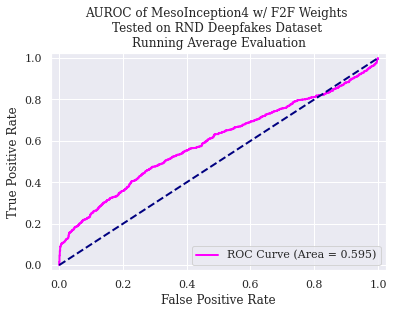

MesoInception4 w/ F2F Weights 
Tested on RND Deepfakes Dataset MesoInception_F2F Deepfakes_rnd MesoInception_F2F_DFrnd
Found 42582 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:14<00:00,  9.92it/s]


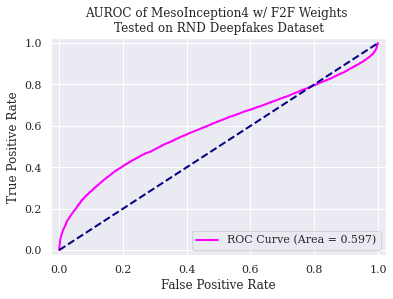

MesoInception4 w/ F2F Weights  
Tested on AVG Face2Face Dataset  
Running Average Evaluation MesoInception_F2F Face2Face_avg MesoInception_F2F_raeonF2Favg
Found 42587 images belonging to 2 classes.


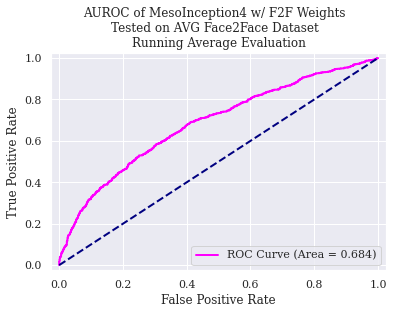

MesoInception4 w/ F2F Weights  
Tested on AVG Face2Face Dataset MesoInception_F2F Face2Face_avg MesoInception_F2F_F2Favg
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:13<00:00,  9.99it/s]


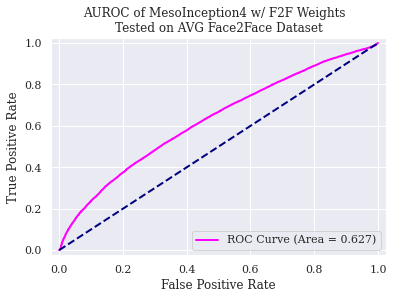

MesoInception4 w/ F2F Weights  
Tested on RND Face2Face Dataset  
Running Average Evaluation MesoInception_F2F Face2Face_rnd MesoInception_F2F_raeonF2Frnd
Found 42587 images belonging to 2 classes.


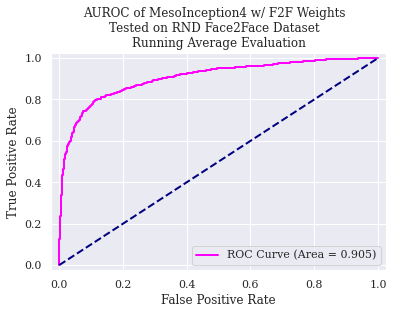

MesoInception4 w/ F2F Weights  
Tested on RND Face2Face Dataset MesoInception_F2F Face2Face_rnd MesoInception_F2F_F2Frnd
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:14<00:00,  9.86it/s]


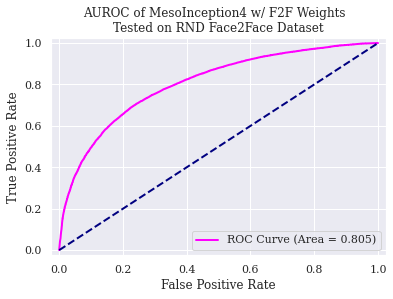

MesoInception4 w/ DF Weights  
Tested on AVG Face2Face Dataset  
Running Average Evaluation MesoInception_DF Face2Face_avg MesoInception_DF_raeonF2Favg
Found 42587 images belonging to 2 classes.


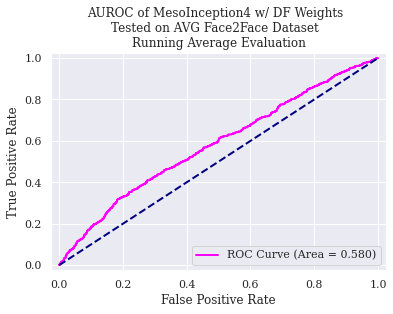

MesoInception4 w/ DF Weights  
Tested on AVG Face2Face Dataset MesoInception_DF Face2Face_avg MesoInception_DF_F2Favg
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:11<00:00, 10.08it/s]


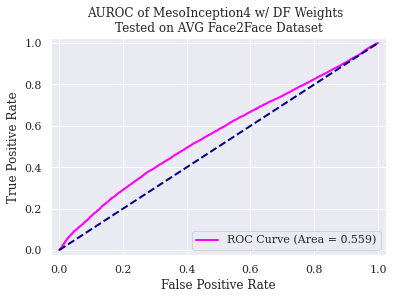

MesoInception4 w/ DF Weights  
Tested on RND Face2Face Dataset  
Running Average Evaluation MesoInception_DF Face2Face_rnd MesoInception_DF_raeonF2Frnd
Found 42587 images belonging to 2 classes.


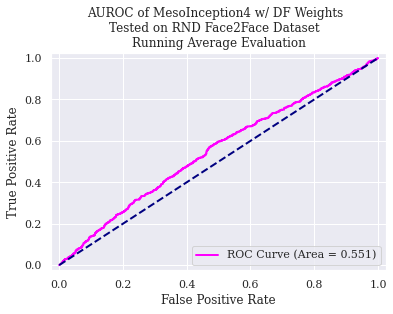

MesoInception4 w/ DF Weights  
Tested on RND Face2Face Dataset MesoInception_DF Face2Face_rnd MesoInception_DF_F2Frnd
Found 42587 images belonging to 2 classes.


100%|██████████| 1330/1330 [02:14<00:00,  9.91it/s]


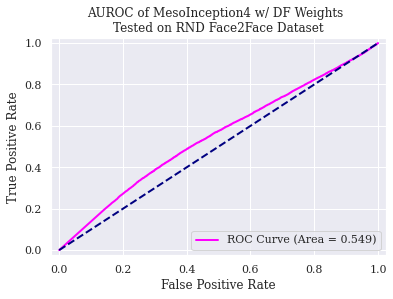

In [13]:
for experiment_name, model_name, testset_name, fname in EXPERIMENTS:
    print(experiment_name, model_name, testset_name, fname)
    fname = f"./Results/{fname}"

    # Pick the correct model
    CLASSIFIER = get_meso_model(model_name)
    _, _, DATASET = get_binary_testset(testset_name)

    IMG_DATAGEN = ImageDataGenerator(rescale=1./255)
    GEN = IMG_DATAGEN.flow_from_directory(DATASET,
                                          target_size=(IMGWIDTH, IMGWIDTH),
                                        #   batch_size=128,
                                          seed=SEED,
                                          class_mode="binary") 
    # possible_batch_sizes = [b for b in range(1, GEN.samples) if not GEN.samples % b]
    # possible_batch_sizes = [b for b in possible_batch_sizes if b<2000][::-1]
    # GEN.batch_size = possible_batch_sizes[0]

    # Evaluate model on test set
    # print(experiment_name)
    y_pred = []
    y_true = []
    if "Running" in experiment_name: # if running in experiment name
        # running average eval, set of images from each video is single data point (not indep.)
        path_to_testset_real_class = f"{DATASET}/{[d for d in os.listdir(DATASET) if 'real' in d][0]}"
        path_to_testset_fake_class = f"{DATASET}/{[d for d in os.listdir(DATASET) if 'real' not in d][0]}"


        for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
            img_dir_list = os.listdir(y_dir_pth)
            Vpths = []
            # loop over all single videos
            for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

                all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
                path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
                V = []

                # loop over all frames from single video
                for path_to_test_img in path_all_imgs_for_vid:
                    t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
                    V += [img_to_array(t)]
                V = np.array(V)**1./255
                y_pred += [np.average(CLASSIFIER.predict(V)).tolist()]
                y_true += [y_label]

    else:
    # normal eval, each image is single data point (indep.)
        for b, (X, y) in tqdm(enumerate(GEN), total=len(GEN)-1):
            y_pred += CLASSIFIER.predict(X).tolist() 
            y_true += y.tolist()
            if b >= (GEN.samples / GEN.batch_size) - 1:
                break
    # y_pred = [yp.tolist() for yp in y_pred]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_rint = np.rint(y_pred)

    # Get AUC
    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _  = roc_curve(y_true, y_pred)

    # If model is worse than random but so much worse that, it's predicting the opposite way
    if auroc < .5:
        auroc = 1 - auroc
        fpr, tpr = tpr, fpr
        y_pred = np.ones(y_pred.shape) - y_pred

    # Get F1, Precision and Recall
    f1 = f1_score(y_true, y_pred_rint)
    prec = precision_score(y_true, y_pred_rint)
    recall = recall_score(y_true, y_pred_rint)
    
    # Plot AUC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"AUROC of {experiment_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"{fname}.pdf") # Save AUC fig
    plt.show()
    
    with open(f"{fname}.txt", "w") as f:
        f.write(f"{experiment_name, model_name, testset_name, fname}\n")
        f.write(f"{auroc=}\n")
        f.write(f"{f1=}\n")
        f.write(f"{prec=}\n")
        f.write(f"{recall=}\n")
        f.write(f"\nfpr={[f for f in fpr]}\n")
        f.write(f"\ntpr={[t for t in tpr]}\n")
        f.write(f"\ny_true={[t for t in y_true]}\n")
        f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}")

In [14]:
# fpath2results = "./Results/"
# txt_files_in_results = os.listdir(fpath2results)
# avg_files = [f"{fpath2results}{f}" for f in txt_files_in_results if "avg.txt" in f]
# rnd_files = [f"{fpath2results}{f}" for f in txt_files_in_results if "rnd.txt" in f]

# def get_auc_from_file(fpath):
#     with open(fpath, "r") as f:
#         f.readline()
#         auc = f.readline()
#     return float(auc.strip().split("=")[-1])

# def get_ytrueNpreds_from_file(fpath):
#     with open(fpath, "r") as f:
#         lines = f.readlines()
#         y_true, y_pred = lines[10], lines[12]
#     return ast.literal_eval(y_true.split("=")[-1]), ast.literal_eval(y_pred.split("=")[-1])


# avg_ytrue, avg_ypred = get_ytrueNpreds_from_file(avg_files[0])
# rnd_ytrue, rnd_ypred = get_ytrueNpreds_from_file(rnd_files[0])
# yy_true = rnd_ypred
# # avg_ypred == rnd_ypred # TRUE

# rnd_aucs = np.array([get_auc_from_file(f) for f in rnd_files])
# avg_aucs = np.array([get_auc_from_file(f) for f in avg_files])

# (avg_aucs.mean(), avg_aucs.std()), (rnd_aucs.mean(), rnd_aucs.std())

In [15]:
# [re.split('_\d+.png', img_name) for img_name in os.listdir(y_dir_pth)]

In [16]:


# path_to_testset = get_binary_testset("DariusAf_Deepfake_Database")
# path_to_testset_real_class = f"{path_to_testset}/{[d for d in os.listdir(path_to_testset) if 'real' in d][0]}"
# path_to_testset_fake_class = f"{path_to_testset}/{[d for d in os.listdir(path_to_testset) if 'real' not in d][0]}"

# # path_to_testset_real_class, path_to_testset_fake_class

# # path_to_testset_subdir = path_to_testset_fake_class

# # imgs_in_real_dir = os.listdir(path_to_testset_subdir)
# # img_name = imgs_in_real_dir[0]

# # y_pred += CLASSIFIER.predict(X).tolist() 
# # y_true += y.tolist()

# CLASSIFIER = get_meso_model("Meso4_DF")

# y_pred = []
# y_true = []
# for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
#     img_dir_list = os.listdir(y_dir_pth)
#     Vpths = []
#     # for img_name in img_dir_list:
#     #     split_img_name = re.split('_\d+.png', img_name)
#     #     og_fname = split_img_name[0]

#     # loop over all single videos
#     for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

#         all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
#         path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
#         V = []

#         # loop over all frames from single video
#         for path_to_test_img in path_all_imgs_for_vid:
#             t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
#             V += [img_to_array(t)]
#         V = np.array(V)**1./255
#         y_pred += [np.average(CLASSIFIER.predict(V)).tolist()]
#         y_true += [y_label]#.tolist()

#         # if len(path_all_imgs_for_vid):
#         #     Vpths += [path_all_imgs_for_vid]
            
#         # break
# y_pred, y_true
# # Vpths[0]
#     # split_img_name = re.split('_\d+.png', img_name)
# # og_fname = split_img_name[0]

# # all_imgs_for_vid = [i for i in imgs_in_real_dir if og_fname in i]
# # path_all_imgs_for_vid = [f"{path_to_testset_subdir}/{i}" for i in all_imgs_for_vid]
# # path_all_imgs_for_vid

# # V = []
# # for path_to_test_img in path_all_imgs_for_vid:
# #     t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
# #     V += [img_to_array(t)]
# # V = np.array(V)**1./255

# # # CLASSIFIER = get_meso_model("Meso4_DF")
# # CLASSIFIER.predict(V)#.tolist() 

In [17]:
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# y_pred_rint = np.rint(y_pred)

# # Get AUC
# auroc = roc_auc_score(y_true, y_pred)
# fpr, tpr, _  = roc_curve(y_true, y_pred)

# # If model is worse than random but so much worse that, it's predicting the opposite way
# if auroc < .5:
#     auroc = 1 - auroc
#     fpr, tpr = tpr, fpr

# # Get F1, Precision and Recall
# f1 = f1_score(y_true, y_pred_rint)
# prec = precision_score(y_true, y_pred_rint)
# recall = recall_score(y_true, y_pred_rint)

# # Plot AUC
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# extra_xylim = 0.025
# plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
# plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # plt.title(f"{experiment_name} AUROC")
# plt.legend(loc="lower right")
# plt.savefig(f"{fname}.png") # Save AUC fig
# plt.show()

In [18]:
# y_pred = []
# y_true = []

# for b, (X, y) in tqdm(enumerate(GEN), total=len(GEN)):
#     y_pred += CLASSIFIER.predict(X).tolist()
#     y_true += y.tolist()
#     if b >= (GEN.samples / GEN.batch_size) - 1:
#         break

In [19]:
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# y_pred_rint = np.rint(y_pred)

In [20]:
# auroc = roc_auc_score(y_true, y_pred)
# fpr, tpr, _  = roc_curve(y_true, y_pred)

# # model is worse than random but so much worse that, it's predicting the opposite way
# if auroc < .5:
#     auroc = 1 - auroc
#     fpr, tpr = tpr, fpr

# f1 = f1_score(y_true, y_pred_rint)
# prec = precision_score(y_true, y_pred_rint)
# recall = recall_score(y_true, y_pred_rint)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auroc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()